In [2]:
import sqlite3
import csv
import sys
import pandas as pd
import numpy as np



In [3]:
from utils import *

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
database_path="census.db"
all_a=['workclass','education','education_num','occupation','relationship','race','sex','native_country','income']
all_m=['age','fnlwgt','capital_gain','capital_loss','hours_per_week']
all_f=['sum','avg','max','min','count']

top_k=5
num_of_partitions=5
delta=0.01
con = sqlite3.connect(database_path)


In [5]:
def create_main_database():
    cur=con.cursor()
    cur.execute("DROP TABLE IF EXISTS census")
    cur.execute("CREATE TABLE IF NOT EXISTS census(age INTEGER,workclass VARCHAR(200) NULL,fnlwgt INTEGER,education VARCHAR(200),education_num INTEGER,marital_status VARCHAR(200),occupation VARCHAR(200) NULL, relationship VARCHAR(200),race VARCHAR(200),sex VARCHAR(200),capital_gain INTEGER,capital_loss INTEGER,hours_per_week INTEGER,native_country VARCHAR(200) NULL,income VARCHAR(200))")
    with open("/content/drive/MyDrive/SEEDB/census+income/adult.data", "r") as file:
        contents = csv.reader(file)
        attribute_tupple=('age','workclass','fnlwgt','education','education_num','marital_status','occupation', 'relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','income')
        _placeholder=place_holder(attribute_tupple)
        insert_records = f"INSERT INTO census VALUES {_placeholder}"
        cur.executemany(insert_records, contents)
    con.commit()
    print("Created Main Database")

def create_married_unmarried_database():
    cur = con.cursor()
    cur.execute("DROP TABLE IF EXISTS married")
    cur.execute("DROP TABLE IF EXISTS unmarried")

    # Create table for married individuals
    cur.execute("CREATE TABLE married AS SELECT * FROM census WHERE TRIM(marital_status) IN ('Married-spouse-absent', 'Married-civ-spouse', 'Separated', 'Widowed', 'Married-AF-spouse')")
    cur.execute("ALTER TABLE married DROP COLUMN marital_status")
    # Create table for unmarried individuals
    cur.execute("CREATE TABLE unmarried AS SELECT * FROM census WHERE TRIM(marital_status) IN ('Divorced', 'Never-married')")
    cur.execute("ALTER TABLE unmarried DROP COLUMN marital_status")
    con.commit()
    print("Created Married and Unmarried Database")

In [6]:
create_main_database()

Created Main Database


In [7]:
create_married_unmarried_database()

Created Married and Unmarried Database


In [8]:
def find_target_table_and_ref_table(target_table,reference_table,a_column,f_m_column,aggregate):
  final_dict={}
  for row in range(len(target_table)):
    if target_table[f_m_column][row]!=0:
      if target_table[a_column][row] not in final_dict:
        final_dict[target_table[a_column][row]]=[[target_table[f_m_column][row]]]
      else:
        final_dict[target_table[a_column][row]][0].append(target_table[f_m_column][row])
    else:
      if target_table[a_column][row] not in final_dict:
        final_dict[target_table[a_column][row]]=[[1e-9]]
      else:
        final_dict[target_table[a_column][row]][0].append(1e-9)
  for row in range(len(reference_table)):
    if reference_table[a_column][row] not in final_dict:
      final_dict[reference_table[a_column][row]]=[[1e-9]]
    if reference_table[f_m_column][row]!=0:
      if len(final_dict[reference_table[a_column][row]])!=2:
        final_dict[reference_table[a_column][row]].append([reference_table[f_m_column][row]])
      else:
        final_dict[reference_table[a_column][row]][1].append(reference_table[f_m_column][row])
    else:
      if len(final_dict[reference_table[a_column][row]])!=2:
        final_dict[reference_table[a_column][row]].append([1e-9])
      else:
        final_dict[reference_table[a_column][row]][1].append(1e-9)

  for key,value in final_dict.items():
    if len(value)!=2:
      final_dict[key].append([1e-9])

  final_dict=get_updated_table_based_on_aggregate_group_by(final_dict,aggregate)

  target_list=[]
  reference_list=[]
  for i in final_dict.values():
    target_list.append(i[0])
    reference_list.append(i[1])
  return target_list,reference_list

def get_updated_table_based_on_aggregate_group_by(final_dict,aggregate):
  if aggregate=='avg':
    for key,value in final_dict.items():
      tar_mean_val=np.mean(value[0])
      ref_mean_val=np.mean(value[1])
      final_dict[key][0]=tar_mean_val
      final_dict[key][1]=ref_mean_val
  elif aggregate=='sum':
    for key,value in final_dict.items():
      tar_mean_val=np.sum(value[0])
      ref_mean_val=np.sum(value[1])
      final_dict[key][0]=tar_mean_val
      final_dict[key][1]=ref_mean_val
  elif aggregate=='max':
    for key,value in final_dict.items():
      tar_mean_val=np.max(value[0])
      ref_mean_val=np.max(value[1])
      final_dict[key][0]=tar_mean_val
      final_dict[key][1]=ref_mean_val
  elif aggregate=='min':
    for key,value in final_dict.items():
      tar_mean_val=np.min(value[0])
      ref_mean_val=np.min(value[1])
      final_dict[key][0]=tar_mean_val
      final_dict[key][1]=ref_mean_val
  elif aggregate=='count':
    for key,value in final_dict.items():
      tar_mean_val=len(value[0])
      ref_mean_val=len(value[1])
      final_dict[key][0]=tar_mean_val
      final_dict[key][1]=ref_mean_val
  return final_dict

### Normal All Views Execution

In [9]:
final_ans={}
for a in all_a:
  for f in all_f:
    for m in all_m:
      married_query=f'select {a},{f}({m}) from married group by {a}'
      unmarried_query=f'select {a},{f}({m}) from unmarried group by {a}'
      cur = con.cursor()
      married_result=cur.execute(married_query)
      target_table=pd.DataFrame(married_result.fetchall())
      cur = con.cursor()
      unmarried_result=cur.execute(unmarried_query)
      reference_table=pd.DataFrame(unmarried_result.fetchall())
      target_list,reference_list=find_target_table_and_ref_table(target_table,reference_table,0,1,'avg')
      final_ans[a,m,f]=kl_divergence(target_list,reference_list)
result_list = sorted(final_ans.items(), key=lambda item: item[1],reverse=True)
print(result_list[:top_k])

[(('relationship', 'fnlwgt', 'sum'), 35.15343207938889), (('relationship', 'capital_gain', 'sum'), 33.97896955835773), (('relationship', 'capital_loss', 'sum'), 30.805513225945674), (('relationship', 'hours_per_week', 'sum'), 28.807373845862152), (('relationship', 'age', 'sum'), 27.669108038094347)]


## Share Based Optimization (Combine Multiple Aggregate)

In [10]:
def combine_multiple_aggregate(a,f_m):
    group_by=" group by "+f"{a}"
    from_married=" from married"
    from_unmarried=" from unmarried"
    query="select "+f"{a}"+ f_m
    married_query=query+from_married+group_by
    unmarried_query=query+from_unmarried+group_by
    return married_query,unmarried_query


In [11]:
f_m=" "
fm_list=[]
for f in all_f:
  for m in all_m:
    f_m=f_m+f",{f}({m})"
    fm_list.append((f,m))
final_ans={}
for a in all_a:
  married_query,unmarried_query=combine_multiple_aggregate(a,f_m)
  cur = con.cursor()
  married_result=cur.execute(married_query)
  target_table=pd.DataFrame(married_result.fetchall())

  cur.close()
  cur = con.cursor()
  unmarried_result=cur.execute(unmarried_query)
  reference_table=pd.DataFrame(unmarried_result.fetchall())
  for f_m_column in range(1,len(fm_list)+1):
    target_list,reference_list=find_target_table_and_ref_table(target_table,reference_table,0,f_m_column,fm_list[f_m_column-1][0])
    final_ans[(a,fm_list[f_m_column-1][0],fm_list[f_m_column-1][1])]=kl_divergence(target_list,reference_list)
result_list = sorted(final_ans.items(), key=lambda item: item[1],reverse=True)
print(result_list[:top_k])

[(('relationship', 'sum', 'fnlwgt'), 35.15343207938889), (('relationship', 'sum', 'capital_gain'), 33.97896955835773), (('relationship', 'sum', 'capital_loss'), 30.805513225945674), (('relationship', 'sum', 'hours_per_week'), 28.807373845862152), (('relationship', 'sum', 'age'), 27.669108038094347)]


## Share Based Optimization (Combine Multiple Aggregate and Group By)

In [12]:
def combine_multiple_aggregate_and_groupby():
    f_m=" "
    fm_list=[]
    for f in all_f:
        for m in all_m:
            f_m=f_m+f",{f}({m})"
            fm_list.append((f,m))

    select="select"
    group_by=" group by"
    where=" where "
    for a in all_a:
        select=select+f" {a},"
        group_by=group_by+f" {a},"
    select=select[:-1]
    group_by=group_by[:-1]

    from_married=" from married"
    from_unmarried=" from unmarried"
    married_query=select+f_m+from_married+group_by
    unmarried_query=select+f_m+from_unmarried+group_by
    return married_query,unmarried_query,fm_list


In [13]:
married_query,unmarried_query,fm_list=combine_multiple_aggregate_and_groupby()
cur = con.cursor()
married_result=cur.execute(married_query)
target_table=pd.DataFrame(married_result.fetchall())
cur.close()
cur = con.cursor()
unmarried_result=cur.execute(unmarried_query)
reference_table=pd.DataFrame(unmarried_result.fetchall())
cur.close()
final_ans={}
for a_column in range(len(all_a)):
    for f_m_column in range(len(all_a),len(all_a)+len(fm_list)):
        target_list,reference_list=find_target_table_and_ref_table(target_table,reference_table,a_column,f_m_column,fm_list[f_m_column-len(all_a)][0])
        final_ans[(all_a[a_column],fm_list[f_m_column-len(all_a)][0],fm_list[f_m_column-len(all_a)][1])]=kl_divergence(target_list,reference_list)
result_list = sorted(final_ans.items(), key=lambda item: item[1],reverse=True)
print(result_list[:top_k])

[(('relationship', 'sum', 'fnlwgt'), 35.15343207938889), (('relationship', 'sum', 'capital_gain'), 33.97896955835655), (('relationship', 'sum', 'capital_loss'), 30.805513225929623), (('relationship', 'sum', 'hours_per_week'), 28.807373845862152), (('relationship', 'sum', 'age'), 27.669108038094347)]


## Share Based Optimization (Combine Multiple Aggregate and Group By) (Combine Reference Query and Target Query)

In [14]:
def combine_multiple_aggregate_and_groupby_and_queries():
  f_m=" "
  fm_list=[]
  for f in all_f:
      for m in all_m:
          f_m=f_m+f",{f}({m})"
          fm_list.append((f,m))

  select="select"
  group_by=" group by"
  where=" where "
  for a in all_a:
      select=select+f" {a},"
      group_by=group_by+f" {a},"
  select=select[:-1]
  group_by=group_by[:-1]
  from_census=" from census"
  case_clause=", CASE WHEN TRIM(marital_status) IN ('Married-spouse-absent', 'Married-civ-spouse', 'Separated', 'Widowed', 'Married-AF-spouse') THEN 1 ELSE 0 END as g1, CASE WHEN TRIM(marital_status) IN ('Divorced', 'Never-married') THEN 1 ELSE 0 END as g2"
  combined_query=select+f_m+case_clause+from_census+group_by+",g1,g2"
  print(fm_list)
  return combined_query,fm_list


In [15]:
import time
start_time = time.time()
combined_query,fm_list=combine_multiple_aggregate_and_groupby_and_queries()
cur = con.cursor()
married_unmarried_result=cur.execute(combined_query)

all_table=pd.DataFrame(married_unmarried_result.fetchall())
print(len(all_table))
cur.close()

married_result=all_table.where(all_table[34]==1).dropna().reset_index()
unmarried_result=all_table.where(all_table[35]==1).dropna().reset_index()
final_ans={}
for a_column in range(len(all_a)):
    for f_m_column in range(len(all_a),len(all_a)+len(fm_list)):
        target_list,reference_list=find_target_table_and_ref_table(target_table,reference_table,a_column,f_m_column,fm_list[f_m_column-len(all_a)][0])
        final_ans[(all_a[a_column],fm_list[f_m_column-len(all_a)][0],fm_list[f_m_column-len(all_a)][1])]=kl_divergence(target_list,reference_list)
result_list = sorted(final_ans.items(), key=lambda item: item[1],reverse=True)
print(result_list[:top_k])
print("\n execution time is ", (time.time()-start_time), "seconds")

[('sum', 'age'), ('sum', 'fnlwgt'), ('sum', 'capital_gain'), ('sum', 'capital_loss'), ('sum', 'hours_per_week'), ('avg', 'age'), ('avg', 'fnlwgt'), ('avg', 'capital_gain'), ('avg', 'capital_loss'), ('avg', 'hours_per_week'), ('max', 'age'), ('max', 'fnlwgt'), ('max', 'capital_gain'), ('max', 'capital_loss'), ('max', 'hours_per_week'), ('min', 'age'), ('min', 'fnlwgt'), ('min', 'capital_gain'), ('min', 'capital_loss'), ('min', 'hours_per_week'), ('count', 'age'), ('count', 'fnlwgt'), ('count', 'capital_gain'), ('count', 'capital_loss'), ('count', 'hours_per_week')]
8513
[(('relationship', 'sum', 'fnlwgt'), 35.15343207938889), (('relationship', 'sum', 'capital_gain'), 33.97896955835655), (('relationship', 'sum', 'capital_loss'), 30.805513225929623), (('relationship', 'sum', 'hours_per_week'), 28.807373845862152), (('relationship', 'sum', 'age'), 27.669108038094347)]

 execution time is  52.71104311943054 seconds


In [16]:
# print(result_list)
top_k_list = result_list[:top_k]
print(top_k_list)

[(('relationship', 'sum', 'fnlwgt'), 35.15343207938889), (('relationship', 'sum', 'capital_gain'), 33.97896955835655), (('relationship', 'sum', 'capital_loss'), 30.805513225929623), (('relationship', 'sum', 'hours_per_week'), 28.807373845862152), (('relationship', 'sum', 'age'), 27.669108038094347)]


In [30]:
select="select "
group_by=" group by "
from_married=" from married"
from_unmarried=" from unmarried"


def visualization(category, numeric, aggregate, connection):
    target_query = f"SELECT {category}, {aggregate}({numeric}) FROM married GROUP BY {category};"
    reference_query = f"SELECT {category}, {aggregate}({numeric}) FROM unmarried GROUP BY {category};"

    cursor1 = connection.cursor()
    cursor2 = connection.cursor()
    cursor1.execute(target_query)
    cursor2.execute(reference_query)

    df_married = pd.DataFrame(cursor1.fetchall(), columns=['Category', 'Value'])
    df_unmarried = pd.DataFrame(cursor2.fetchall(), columns=['Category', 'Value'])

    merged_df = pd.merge(df_married, df_unmarried, how='outer', on='Category', suffixes=['_Married', '_Unmarried'])
    merged_df.fillna(0, inplace=True)


    plot_data = {
        'Married': list(merged_df['Value_Married'].astype(float)),
        'Unmarried': list(merged_df['Value_Unmarried'].astype(float))
    }
    df_bar = pd.DataFrame(plot_data, index=list(merged_df['Category']))

    ax = df_bar.plot.bar(xlabel=category, ylabel=f'{aggregate}({numeric})', rot=90, figsize=(8, 5), color= {
      "#c27ba0",
      "#93c47d",
      "#8e7cc3",
      "#ffd966",
    }, edgecolor='black')
    return ax

(('relationship', 'sum', 'fnlwgt'), 35.15343207938889)
(('relationship', 'sum', 'capital_gain'), 33.97896955835655)
(('relationship', 'sum', 'capital_loss'), 30.805513225929623)
(('relationship', 'sum', 'hours_per_week'), 28.807373845862152)
(('relationship', 'sum', 'age'), 27.669108038094347)


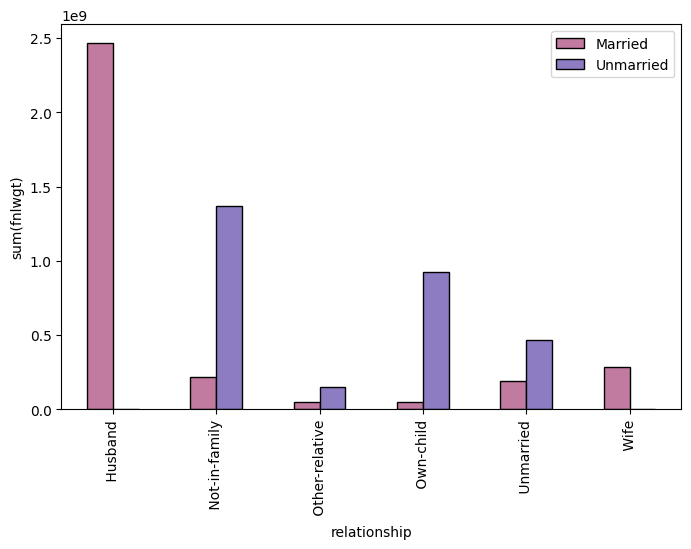

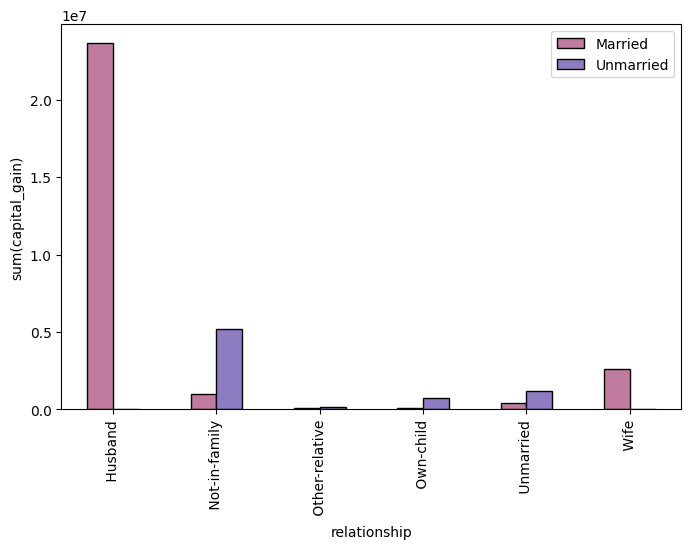

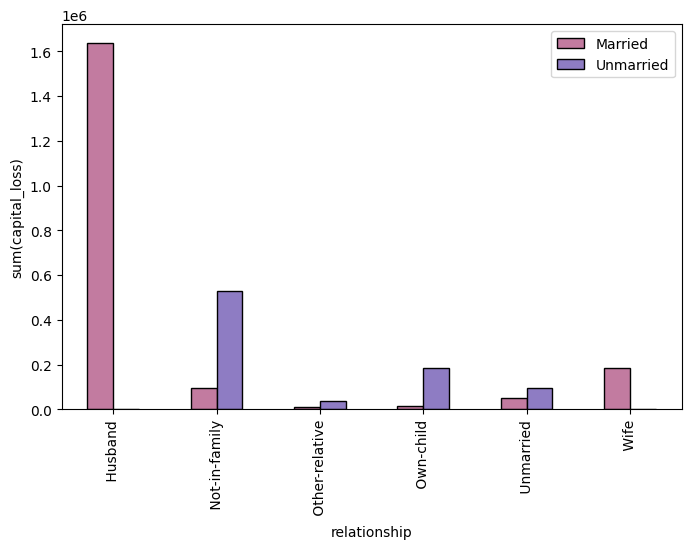

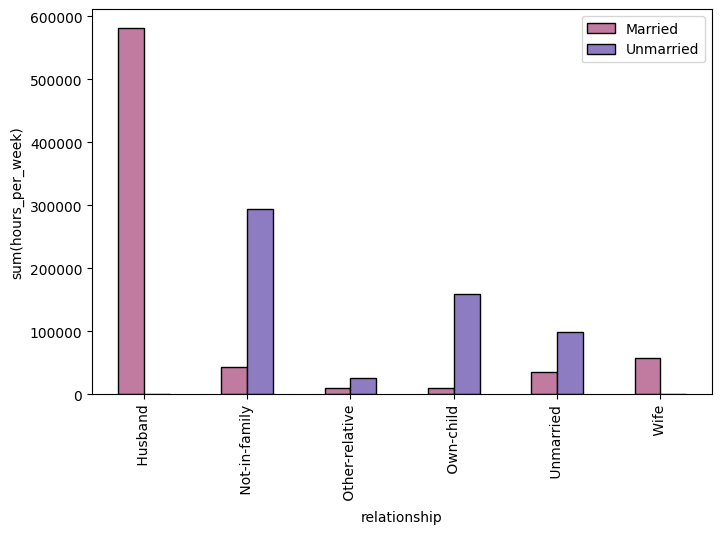

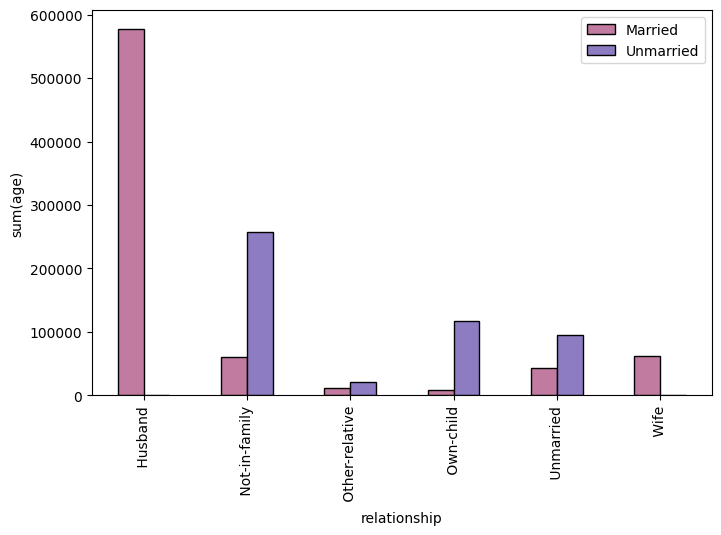

In [34]:
import matplotlib.pyplot as plt
for row in top_k_list:
    print(row)
    visualization(row[0][0], row[0][2], row[0][1], con)

    plt.savefig(f"/content/drive/MyDrive/SEEDB/census+income/myImagePDF_{row}.pdf", format="pdf", bbox_inches="tight")

## Pruning Based Method (Interval Based Method)

In [35]:
def find_mean_and_bound(res_dict,num_of_partitions,delta):
    stats_dict={}
    for key,values in res_dict.items():
        mean=np.mean(values)
        #here I have done len(values)+1 as I did not want log(log(1)) to throw any error
        ci=confidence_interval(len(values)+1,num_of_partitions,delta)
        upper_bound=mean+ci
        lower_bound=mean-ci
        stats_dict[key]=(mean,upper_bound,lower_bound)
    return stats_dict

In [36]:
start_time = time.time()
married_query,unmarried_query,fm_list=combine_multiple_aggregate_and_groupby()
cur = con.cursor()
married_result=cur.execute(married_query)
target_table=pd.DataFrame(married_result.fetchall())
cur.close()
cur = con.cursor()
unmarried_result=cur.execute(unmarried_query)
reference_table=pd.DataFrame(unmarried_result.fetchall())
cur.close()
target_table_partitions=np.array_split(target_table,num_of_partitions)
target_table_partitions=reset_index(target_table_partitions)
reference_table_partitions=np.array_split(reference_table,num_of_partitions)
reference_table_partitions=reset_index(reference_table_partitions)
res_dict={}
removed_views=[]
for i in range(num_of_partitions):
  print(i)
  for a_column in range(len(all_a)):
    for f_m_column in range(len(all_a),len(all_a)+len(fm_list)):
      view_key=(all_a[a_column],fm_list[f_m_column-len(all_a)][0],fm_list[f_m_column-len(all_a)][1])
      if removed_views:
        if view_key in removed_views:
            # go to next iteration
            continue
      target_list,reference_list=find_target_table_and_ref_table(target_table_partitions[i],reference_table_partitions[i],a_column,f_m_column,fm_list[f_m_column-len(all_a)][0])

      if view_key in res_dict:
        res_dict[view_key].append(kl_divergence(target_list,reference_list))
      else:
        res_dict[view_key]=[kl_divergence(target_list,reference_list)]
  stats_dict=find_mean_and_bound(res_dict,num_of_partitions,delta)
  lower_bound=[]

  for view,m_u_l_bound in stats_dict.items():
    lower_bound.append(m_u_l_bound[2])
  sorted_lower_bound=sorted(lower_bound,reverse=True)
  k_lower_bound=sorted_lower_bound[top_k-1]
  views_to_remove = []
  for view,m_u_l_bound in stats_dict.items():
    if m_u_l_bound[1]<k_lower_bound:
      removed_views.append(view)
      views_to_remove.append(view)
  for view in views_to_remove:
    del stats_dict[view]
    del res_dict[view]

final_ans={}
for key,values in res_dict.items():
  final_ans[key]=np.mean(values)
final_ans = list(sorted(final_ans.items(), key=lambda item: item[1],reverse=True))
print("\n execution time is ", (time.time()-start_time), "seconds")
print(final_ans)

0
1
2
3
4

 execution time is  14.621128797531128 seconds
[(('relationship', 'sum', 'fnlwgt'), 33.431711604981096), (('relationship', 'sum', 'capital_gain'), 32.0091390532803), (('relationship', 'sum', 'capital_loss'), 28.89881248818101), (('relationship', 'sum', 'hours_per_week'), 27.057359339465684), (('relationship', 'sum', 'age'), 26.01450142355511)]


(('relationship', 'sum', 'fnlwgt'), 33.431711604981096)
(('relationship', 'sum', 'capital_gain'), 32.0091390532803)
(('relationship', 'sum', 'capital_loss'), 28.89881248818101)
(('relationship', 'sum', 'hours_per_week'), 27.057359339465684)
(('relationship', 'sum', 'age'), 26.01450142355511)


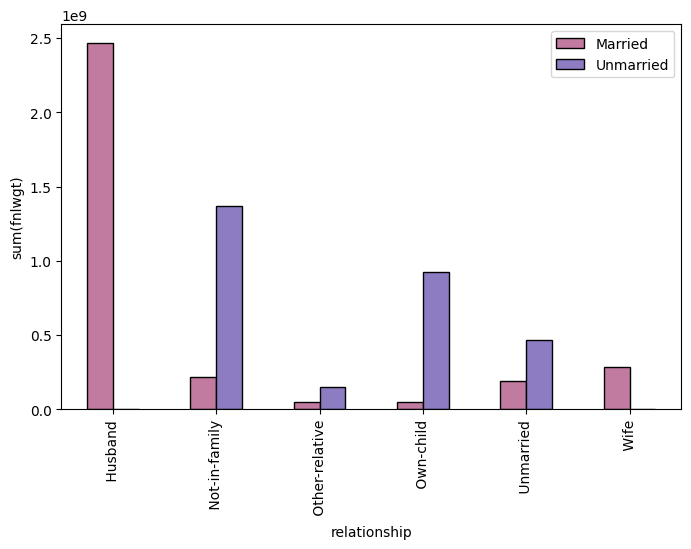

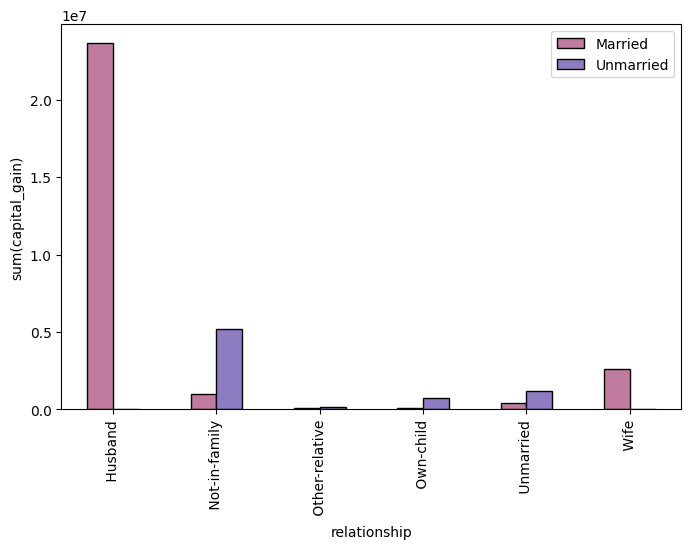

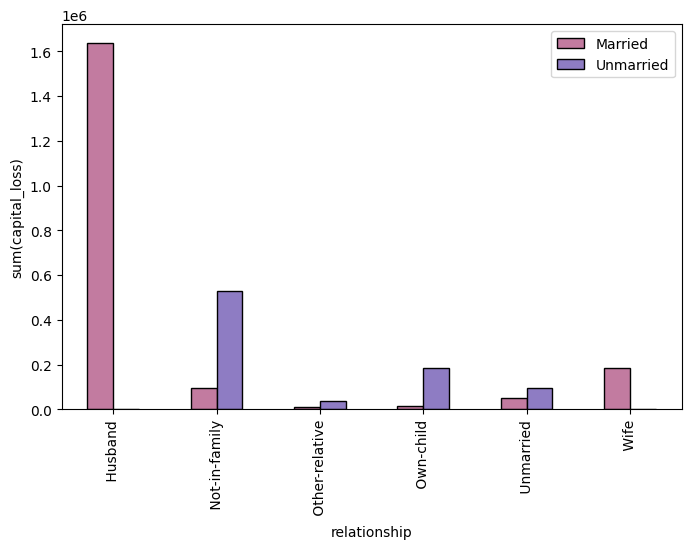

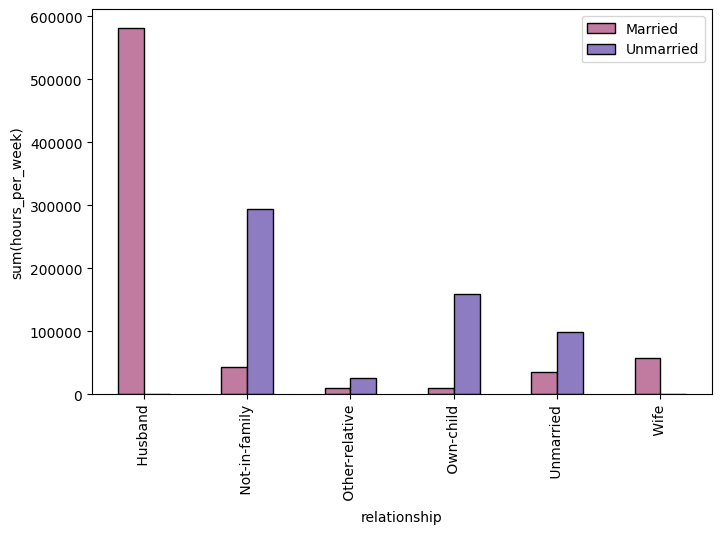

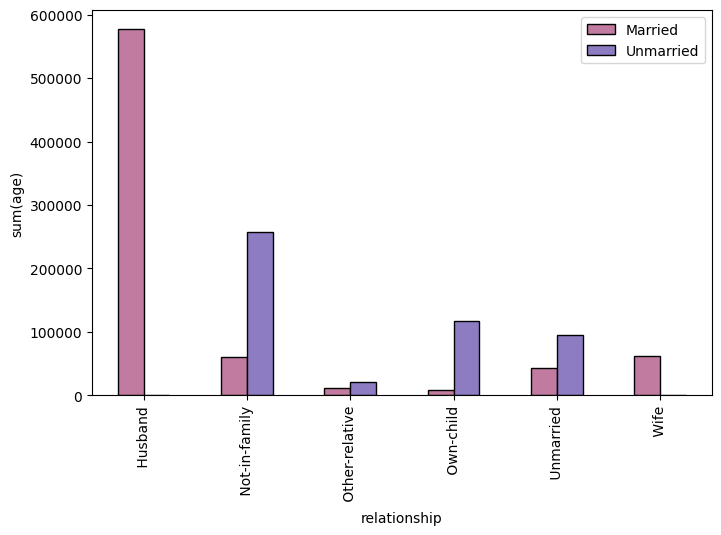

In [37]:
top_k_list = final_ans[:top_k]
for row in top_k_list:
    print(row)
    visualization(row[0][0], row[0][2], row[0][1], con)
    plt.savefig(f"/content/drive/MyDrive/SEEDB/census+income/prune_images_{row}.pdf", format="pdf", bbox_inches="tight")